<a href="https://colab.research.google.com/github/jimmy-pink/colab-playground/blob/main/pre-trained/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 使用VGG16预训练模型

### 需求描述
有一批约800张文件夹图标的png图片，需要将这批图片分类：  

- 按形状分
  - 标准
  - 折叠1
  - 折叠2
  - 折叠3
  - 折叠4
  - 长方形-长
  - 长方形-短
  - 文件堆叠

- 按用途
  - 仅纯净背景
  - 带有前置主体对象的图标

### 面临挑战

按用途分类时的挑战
1. 许多被标记为纯净的图案实际并不纯净， 上面一般会有均匀的形状 纹理点缀
2. 有的形状较为特征， 为半折叠的文件 如图片，这种作为纯净背景时，主体一般镶嵌在中间，如何让机器理解这类图片哪种是纯净，哪种是已镶嵌好像有点困难

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

import os
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# 挂载 Google Drive
base_dir = '/content/drive/MyDrive/data/folder-icon-images/'  # Google Drive 中的图像文件夹路径
drive_train_validate_dir = base_dir + "train_validate"

Mounted at /content/drive


## 识别标准文件夹的模型训练

二分类问题  
本模型负责判断一个图片是否是标准的文件夹形状

### 准备数据

In [51]:
local_image_dir = "/content/data/isfolder/"
standard_dir = local_image_dir + 'standard'  # 新建的 "standard" 文件夹
non_standard_dir = local_image_dir + 'non_standard'  # 新建的 "non-standard" 文件夹

In [52]:
# 创建新的子文件夹
os.makedirs(standard_dir, exist_ok=True)
os.makedirs(non_standard_dir, exist_ok=True)

# 获取文件夹中的所有文件
for filename in os.listdir(drive_train_validate_dir):
    # 检查是否是图像文件（假设是jpg格式）
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # 检查文件名前缀是否是 "standard"
        if filename.startswith('standard'):
            # 将文件移到 "standard" 文件夹
            shutil.copy(os.path.join(drive_train_validate_dir, filename), os.path.join(standard_dir, filename))
        else:
            # 将文件移到 "non-standard" 文件夹
            shutil.copy(os.path.join(drive_train_validate_dir, filename), os.path.join(non_standard_dir, filename))

print("Images have been classified into 'standard' and 'non-standard'.")

Images have been classified into 'standard' and 'non-standard'.


In [10]:
print("Standard images (symlinks):")
print(os.listdir(standard_dir))

Standard images (symlinks):
['standard_pure_119.png', 'standard_nonpure_97.png', 'standard_nonpure_230.png', 'standard_nonpure_169.png', 'standard_pure_63.png', 'standard_nonpure_181.png', 'standard_nonpure_133.png', 'standard_nonpure_23.png', 'standard_nonpure_132.png', 'standard_pure_87.png', 'standard_nonpure_43.png', 'standard_nonpure_91.png', 'standard_pure_30.png', 'standard_pure_66.png', 'standard_nonpure_120.png', 'standard_nonpure_75.png', 'standard_pure_23.png', 'standard_nonpure_82.png', 'standard_nonpure_177.png', 'standard_nonpure_33.png', 'standard_pure_36.png', 'standard_pure_58.png', 'standard_nonpure_124.png', 'standard_nonpure_20.png', 'standard_pure_101.png', 'standard_nonpure_114.png', 'standard_nonpure_147.png', 'standard_nonpure_74.png', 'standard_nonpure_136.png', 'standard_nonpure_188.png', 'standard_nonpure_71.png', 'standard_nonpure_196.png', 'standard_pure_75.png', 'standard_pure_37.png', 'standard_pure_35.png', 'standard_pure_47.png', 'standard_nonpure_19.pn

### 数据处理与划分

In [53]:
# 设置数据增强
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)

# 使用 flow_from_directory 加载训练数据
# 数据增强 + 归一化
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    validation_split=0.3  # 30% 作为验证集
)

# 训练集生成器
train_generator = train_datagen.flow_from_directory(
    local_image_dir,
    target_size=(224, 224),  # VGG16 需要 224x224，将原图转成224*224
    batch_size=32,
    class_mode='binary',  # 二分类用 binary，多分类用 categorical
    subset='training'  # 指定是训练集
)

# 验证集生成器
validation_generator = train_datagen.flow_from_directory(
    local_image_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # 指定是验证集
)
print(f"找到的训练样本数: {train_generator.samples}")
print(f"找到的验证样本数: {validation_generator.samples}")
images, labels = next(train_generator)
print("图像形状:", images.shape)  # 应为 (batch_size, 224, 224, 3)
print("标签形状:", labels.shape)

Found 605 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
找到的训练样本数: 605
找到的验证样本数: 259
图像形状: (32, 224, 224, 3)
标签形状: (32,)


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### 定义模型

In [54]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [55]:
model = Sequential([
    base_model,  # 假设你已经加载了预训练模型，如 VGG16
    Flatten(),
    Dense(1024, activation='relu',
          kernel_regularizer=regularizers.l2(0.01)),  # 添加L2正则化
    Dropout(0.5),  # 添加Dropout层，丢弃50%的神经元
    Dense(1, activation='sigmoid')  # 最后一层对于二分类任务使用sigmoid激活
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### 模型训练

In [56]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') >= 0.95 and logs.get('val_loss') < 0.35 ):
            self.model.stop_training = True
callbacks = myCallback()
# 训练模型
model.fit(train_generator,
          epochs=100,
          validation_data=validation_generator,
          callbacks=[callbacks])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7676 - loss: 13.9697 - val_accuracy: 0.9537 - val_loss: 4.3928
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.9757 - loss: 3.5419 - val_accuracy: 0.9614 - val_loss: 2.4076
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 275ms/step - accuracy: 0.9760 - loss: 1.7535 - val_accuracy: 0.9575 - val_loss: 1.6034
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 273ms/step - accuracy: 0.9802 - loss: 1.1150 - val_accuracy: 0.9459 - val_loss: 1.2756
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 287ms/step - accuracy: 0.9839 - loss: 0.8381 - val_accuracy: 0.9575 - val_loss: 1.0483
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 350ms/step - accuracy: 0.9867 - loss: 0.6163 - val_accuracy: 0.9228 - val_loss: 0.8668
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 283ms/step - accuracy: 0.9888 - loss: 0.4341 - val_accuracy: 0.9575 - val_loss: 0.6832
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step - accuracy: 0.9789 - loss: 0.3739 - val_accu

In [57]:
# 可选： 模型保存
save_dir = '/content/drive/MyDrive/Google-AI-Studio/saved_models'
# 如果目录不存在，则创建
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [58]:
model.save(f'{save_dir}/folder_icon_shape_isstandard_predict_model.h5')

### 模型评估

### 模型预测

In [15]:
drive_test_dir = base_dir + "test_folder_recognition"

In [39]:
def predict_image(model, img_path):
    # 1. 加载图片并调整为模型输入大小
    img = image.load_img(img_path, target_size=(224, 224))  # 对图像进行大小调整
    img_array = image.img_to_array(img)  # 转换为数组
    img_array = np.expand_dims(img_array, axis=0)  # 增加一个维度，符合批量输入要求

    # 2. 预处理图像（根据模型的预处理要求）
    img_array = preprocess_input(img_array)  # 对图像进行预处理（适应VGG16的要求）

    # 3. 使用模型进行预测
    prediction = model.predict(img_array)  # 预测结果

    # 4. 返回预测结果
    return prediction

In [16]:
# 使用模型进行预测
for item in os.listdir(drive_test_dir):
    item_path = os.path.join(drive_test_dir, item)
    if os.path.isfile(item_path):
        prediction = predict_image(model, item_path)  # 传递正确的路径
        if prediction > 0.5:
            # 输出预测结果
            print(f"{item_path} Prediction:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
/content/drive/MyDrive/data/folder-icon-images/test_folder_recognition/test-1.png Prediction: [[1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
/content/drive/MyDrive/data/folder-icon-images/test_folder_recognition/test-5.jpeg Prediction: [[1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
/content/drive/MyDrive/data/folder-icon-images/test_folder_recognition/book-folder-icon-18-256x256.png Prediction: [[1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
/content/drive/MyDrive/data/folder-icon-images/test_folder_recognition/book-folder-icon-23-256x256.png Prediction: [[1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
/content/drive/MyDrive/data/folder-icon-images/test_folder_re

现在 模型可以判断如些是标准的文件夹图片

## 判断是否纯净文件夹的模型训练


|关键点|优化方法|
|---|---|
|**数据预处理**|HSV 色彩增强、边缘检测|
|**数据增强**|纯净图案：仿射变换；非纯净图案：遮挡+噪声|
|**模型微调**|冻结 VGG16 底层，微调高层|
|**评估**|混淆矩阵 + 可视化预测|

### 准备数据

In [3]:
local_image_dir = "/content/data/is_pure/"
standard_dir = local_image_dir + 'pure'  # 新建的 "standard" 文件夹
non_standard_dir = local_image_dir + 'non_pure'  # 新建的 "non-standard" 文件夹

In [8]:

# 创建新的子文件夹
os.makedirs(standard_dir, exist_ok=True)
os.makedirs(non_standard_dir, exist_ok=True)

# 获取文件夹中的所有文件
for filename in os.listdir(drive_train_validate_dir):
    # 检查是否是图像文件（假设是jpg格式）
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # 检查文件名前缀是否是 "standard"
        if 'pure' not in filename or not filename.startswith("standard"):
            continue
        if 'nonpure' in filename:
            # 将文件移到 "standard" 文件夹
            shutil.copy(os.path.join(drive_train_validate_dir, filename), os.path.join(standard_dir, filename))
        else:
            # 将文件移到 "non-standard" 文件夹
            shutil.copy(os.path.join(drive_train_validate_dir, filename), os.path.join(non_standard_dir, filename))

print("Images have been classified into 'pure' and 'non-pure'.")

Images have been classified into 'pure' and 'non-pure'.


### 数据处理与划分

#### 图像颜色和纹理增强

In [29]:
import cv2
def preprocess_image(image):
    # 转为 HSV 空间
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # 对 S 和 V 通道做直方图均衡化（需先转换为单通道）
    hsv[:,:,1] = cv2.equalizeHist(hsv[:,:,1].astype('uint8'))  # 饱和度通道
    hsv[:,:,2] = cv2.equalizeHist(hsv[:,:,2].astype('uint8'))  # 亮度通道
    # 转回 RGB
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return image

# 使用灰度图像即可，只关心纹路， 不关心颜色
def preprocess_gray_image(image):
    # 转换为灰度图像
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

In [30]:
# 设置数据增强
pure_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect',
    preprocessing_function=preprocess_image,  # 自定义预处理
    validation_split=0.3
)

# 训练集生成器
train_generator = pure_datagen.flow_from_directory(
    local_image_dir,
    target_size=(224, 224),  # VGG16 需要 224x224，将原图转成224*224
    batch_size=32,
    class_mode='binary',  # 二分类用 binary，多分类用 categorical
    subset='training'  # 指定是训练集
)

# 验证集生成器
validation_generator = pure_datagen.flow_from_directory(
    local_image_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # 指定是验证集
)
print(f"找到的训练样本数: {train_generator.samples}")
print(f"找到的验证样本数: {validation_generator.samples}")
images, labels = next(train_generator)
print("图像形状:", images.shape)  # 应为 (batch_size, 224, 224, 3)
print("标签形状:", labels.shape)

Found 701 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
找到的训练样本数: 701
找到的验证样本数: 300
图像形状: (32, 224, 224, 3)
标签形状: (32,)


### 模型创建

In [32]:
# 加载 VGG16，冻结前 15 层（只训练后面几层）
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import AdamW

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3 ))
for layer in base_model.layers[:100]:  # 冻结部分层
    layer.trainable = False
# 构建二分类模型
model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # 增大 L2 系数
    Dropout(0.6),  # 提高 Dropout 比率
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

### 模型训练 和 预测

In [33]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
# 获取训练集的真实标签（需确保 train_generator.classes 是整数标签 0/1）
y_train = train_generator.classes
# 计算类别权重（classes 需是 NumPy 数组）
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),  # 自动提取唯一类别（如 [0, 1]）
    y=y_train
)
# 转换为字典格式
class_weights = {i: weight for i, weight in enumerate(class_weights)}
print("类别权重:", class_weights)

类别权重: {0: np.float64(0.7929864253393665), 1: np.float64(1.3532818532818534)}


In [35]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights  # 如果数据不均衡
)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.7868 - loss: 3.2931 - val_accuracy: 0.8967 - val_loss: 3.2050
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step - accuracy: 0.7415 - loss: 3.1932 - val_accuracy: 0.8967 - val_loss: 3.2616
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.8110 - loss: 2.9932 - val_accuracy: 0.8833 - val_loss: 2.9360
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.7577 - loss: 2.8807 - val_accuracy: 0.8767 - val_loss: 2.9354
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.8047 - loss: 2.7382 - val_accuracy: 0.7633 - val_loss: 3.0141
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - accuracy: 0.7702 - loss: 2.6334 - val_accuracy: 0.8167 - val_loss: 2.8691
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.7997 - loss: 2.5155 - val_accuracy: 0.7800 - val_loss: 2.8228
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step - accuracy: 0.7764 - loss: 2.4187 - val_accuracy: 0.

In [36]:
drive_test_pure_dir = base_dir + "test_pure_classification"

In [44]:
# 使用模型进行预测
for item in os.listdir(drive_test_pure_dir):
    item_path = os.path.join(drive_test_pure_dir, item)
    if os.path.isfile(item_path):
        prediction = predict_image(model, item_path)  # 传递正确的路径
        if prediction > 0.5:
            # 输出预测结果
            print(f"{item_path} Prediction:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
/content/drive/MyDrive/data/folder-icon-images/test_pure_classification/test-1.png Prediction: [[0.6510177]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
/content/drive/MyDrive/data/folder-icon-images/test_pure_classification/test-3.png Prediction: [[0.541286]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
/content/drive/MyDrive/data/folder-icon-images/test_pure_classification/test-4.jpeg Prediction: [[0.62434393]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
/content/drive/MyDrive/data/folder-icon-images/test_pure_classification/test-5.jpeg Prediction: [[0.9762828]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
/content/drive/MyDrive/data/folder-icon-images/test_pure_classification/book-folder-icon-18-256x256.png Prediction: [[0.9654546]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
/content/drive/MyDrive/data/folder-icon-images/test_pure_classification/book-folder-icon-23-256x256.png Prediction: [[0.99883527]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


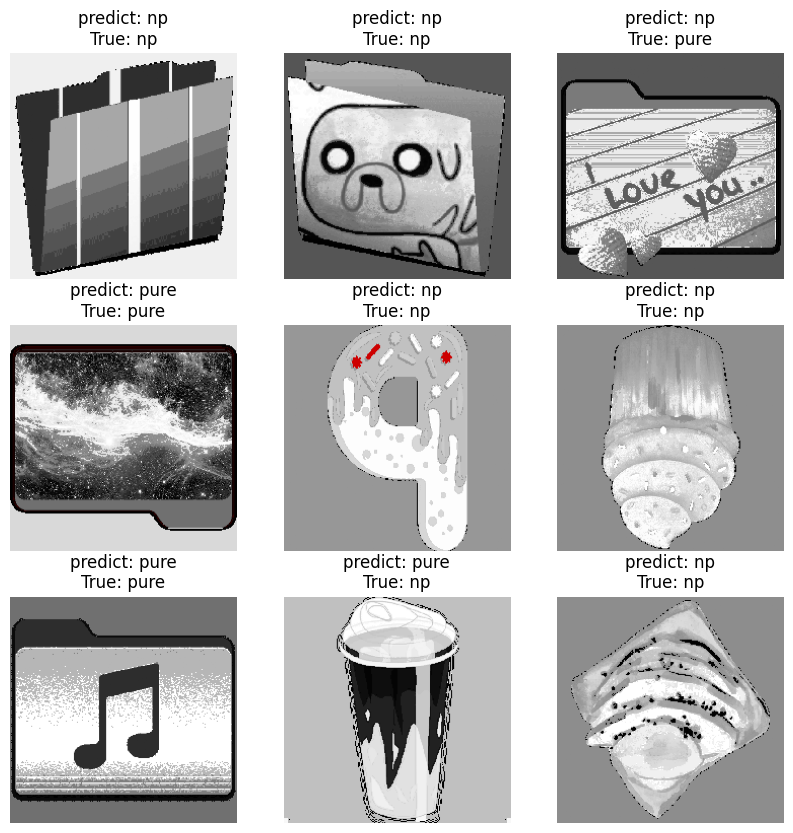

In [47]:
import matplotlib.pyplot as plt
import numpy as np
# 从测试集取一批数据
test_images, test_labels = next(validation_generator)
predictions = model.predict(test_images)
# 显示预测结果
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(test_images[i])
    pred = "pure" if predictions[i] > 0.5 else "np"
    true = "pure" if test_labels[i] == 1 else "np"
    plt.title(f"predict: {pred}\nTrue: {true}")
    plt.axis('off')
plt.show()

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 517ms/step


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


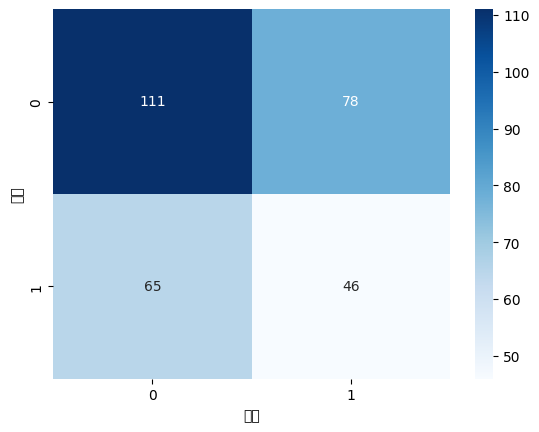

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# 获取所有测试数据预测
y_pred = model.predict(validation_generator)
y_pred = (y_pred > 0.5).astype(int)
y_true = validation_generator.classes
# 绘制混淆矩阵
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('预测')
plt.ylabel('真实')
plt.show()

预测结果很不理想，最大原因可能在于数据集标签的问题